### Principal Component Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
path = './data/ex7data1.mat'
data = loadmat(path)
X = data['X']

X.shape

(50, 2)

In [3]:
def plot_data(X):
    plt.figure(figsize=(7, 6))
    plt.scatter(X[:, 0], X[:, 1], marker='o', facecolors='none', edgecolors='b')
    plt.xlabel('X1')
    plt.ylabel('X2')

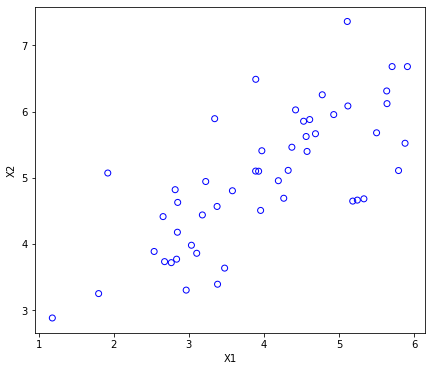

In [4]:
# 绘制数据点
plot_data(X)

In [5]:
# 特征归一化
def feature_normalize(X):
    mu = np.mean(X, axis=0)
    X_norm = (X - mu) / np.std(X, axis=0)
    return mu, X_norm

In [6]:
mu, X_norm = feature_normalize(X)

In [7]:
def pca(X_norm):
    sigma = np.dot(X_norm.T, X_norm) / X_norm.shape[0] # covariance matrix
    U, S, V = np.linalg.svd(sigma) 
    return U, S, V

In [8]:
U, S, V = pca(X_norm)
U, S, V

(array([[-0.70710678, -0.70710678],
        [-0.70710678,  0.70710678]]),
 array([1.73553038, 0.26446962]),
 array([[-0.70710678, -0.70710678],
        [-0.70710678,  0.70710678]]))

Text(0.5, 1.0, 'Computed eigenvectors of the dataset')

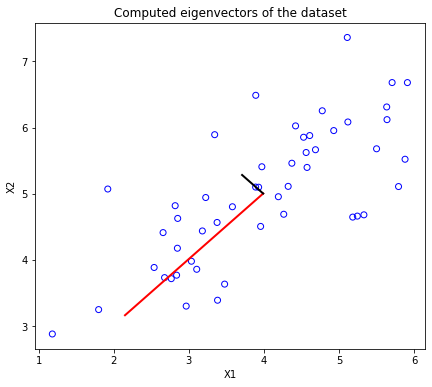

In [9]:
plot_data(X)

# 绘制特征向量，两个不同的方向
plt.plot([mu[0], mu[0] + 1.5 * S[0] * U[0, 0]], [mu[1], mu[1] + 1.5 * S[0] * U[0, 1]], color='r', linewidth=2) # 两点之间的直线
plt.plot([mu[0], mu[0] + 1.5 * S[1] * U[1, 0]], [mu[1], mu[1] + 1.5 * S[1] * U[1, 1]], color='k', linewidth=2)
plt.title('Computed eigenvectors of the dataset')

#### Dimensionality Reduction with PCA

In [10]:
# 数据投影
def projection(X_norm, U, k):
    U_reduce = U[:, :k]
    Z = np.dot(X_norm, U_reduce)
    return Z

In [11]:
Z = projection(X_norm, U, k=1)

# 第一个样本投影后的值
Z[0], Z.shape

(array([1.49631261]), (50, 1))

In [12]:
# 恢复被投影后的数据
def recover_data(Z, U, k):
    U_reduce = U[:, :k]
    X_rec = np.dot(Z, U_reduce.T)  # (50, 1) * (1, 2)
    return X_rec

In [13]:
X_rec = recover_data(Z, U, k=1)
# 第一个样本被恢复后的值
X_rec[0, :]

array([-1.05805279, -1.05805279])

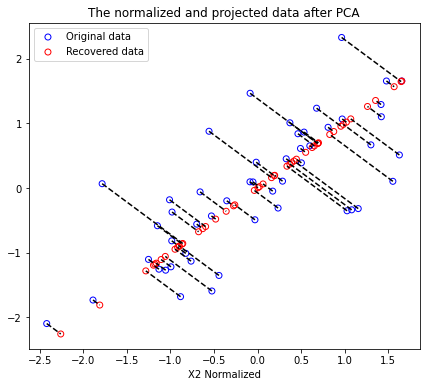

In [14]:
# 可视化映射
# 归一化后的最初样本
plt.figure(figsize=(7, 6))
plt.scatter(X_norm[:, 0], X_norm[:, 1], marker='o', facecolors='none', edgecolors='b', label='Original data')
plt.scatter(X_rec[:, 0], X_rec[:, 1], marker='o', facecolors='none', edgecolors='r', label='Recovered data')

for i in range(X_norm.shape[0]):
    plt.plot([X_norm[i, 0], X_rec[i, 0]], [X_norm[i, 1], X_rec[i, 1]], 'k--')
    
plt.xlabel('X1 Normalized')
plt.xlabel('X2 Normalized')
plt.title('The normalized and projected data after PCA')
plt.legend()

#### Face image Dataset

In [15]:
path = './data/ex7faces.mat'
data = loadmat(path)
X = data['X']
X.shape # (32, 32) --> 32 * 32 = 1024，每一行表示一张图片

(5000, 1024)

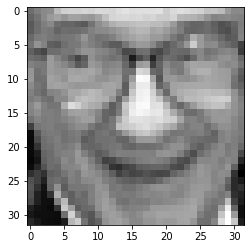

In [16]:
# 显示第一张图片，注意将p转置，以显示正面图片
p = X[0].reshape(32, 32)
plt.imshow(p.T, cmap = 'gray')

In [17]:
def display_image(X, rows=10, cols=10):
    height, width = 32, 32
    
    big_picture = np.zeros((height * rows, width * cols))
    
    irow, icol = 0, 0
    for i in range(rows * cols):
        if icol==cols:
            irow += 1
            icol = 0
        img = X[i].reshape(height, width).T
        # 将100张图片按行优先合成一张大图
        big_picture[irow * height : irow * height + height, icol * width : icol * width + width] = img
        icol += 1
        
    plt.figure(figsize=(8, 8))    
    plt.imshow(big_picture, cmap='gray')

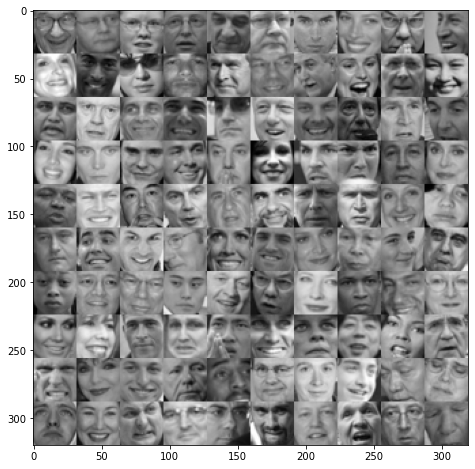

In [18]:
# 展示前100张图片
display_image(X, rows=10, cols=10)

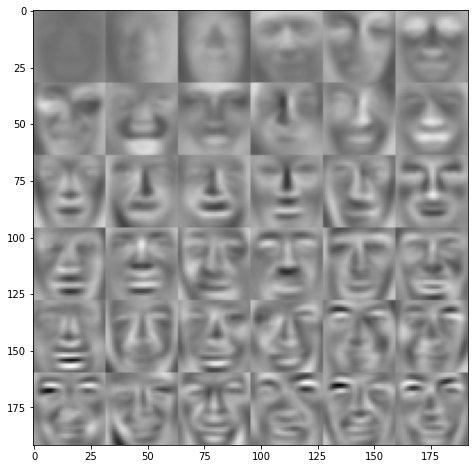

In [19]:
mu, X_norm = feature_normalize(X)

U, S, V = pca(X_norm)

# 数据集中的主成分，U的前36列（特征向量）
display_image(U[:, :36].T, 6, 6)


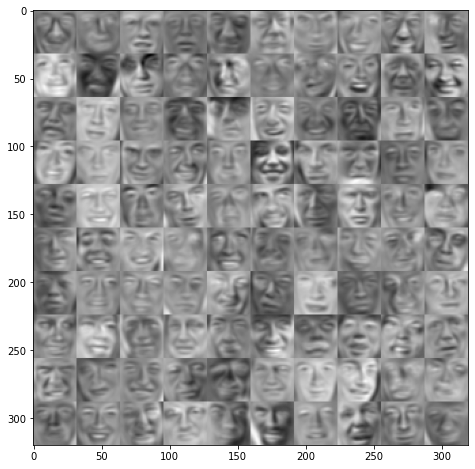

In [20]:
# 选取前100个主成分，1024->100
Z = projection(X_norm, U, k=100)

# 100->1024
X_rec = recover_data(Z, U, k=100)

# 恢复后的图片
display_image(X_rec)

####  Optional exercise: PCA for visualization

In [21]:
# A:小鸟图片
A = loadmat('./data/bird_small.mat')['A']
A.shape

(128, 128, 3)

In [22]:
# 随机选择簇中心
def random_centroids(X, K):
    idx = np.random.randint(X.shape[0], size=K)
    return X[idx, :]


# 计算每个样本到每个簇中心的距离，从而将样本分配给距离最近的簇
def find_closest_centroids(X, centroids):
    m = X.shape[0]
    k = centroids.shape[0]
    idx = np.zeros(m)
    
    for i in range(m):
        dis = np.zeros(k)
        for j in range(k):
            dis[j] = np.sum((X[i, :] - centroids[j, :])  ** 2)  # 计算当前点距离其他簇的距离
        idx[i] = np.argmin(dis) # 返回向量dis最小元素的下标
        
    return idx

# 计算簇的中心-某一簇对应样本的平均值
def compute_centroids(X, idx, K):
    new_X = []
    for i in range(K):
        new_X.append(np.array([X[j, :] for j in range(len(idx)) if idx[j]==i]))
    return np.array([np.mean(xi, axis=0) for xi in new_X])
    
    

# K-means algorithm 
def run_kmeans(X, init_centroids, K, iters):
    centroids_cords = []
    centroids_cords.append(init_centroids)
    centroids = init_centroids
    for i in range(iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, K)
        
        centroids_cords.append(centroids)
    return idx, centroids_cords

def init_list_of_objects(size):
    list_of_objects = list()
    for i in range(0,size):
        list_of_objects.append( list() ) #different object reference each time
    return list_of_objects

In [23]:
A = A / 255 # 归一化

X = np.reshape(A, (A.shape[0] * A.shape[1], A.shape[2])) # (128, 128, 3) -> (16384, 3)

K = 16

init_centroids = random_centroids(X, K) # 随机初始化
 
idx, centroids_cords = run_kmeans(X, init_centroids, K, iters=10) # 执行K-means算法
 
final_centroids = centroids_cords[-1] 

idx = find_closest_centroids(X, final_centroids)  # 根据最后的centroids对样本进行分类

In [24]:
# 将点分类
group = init_list_of_objects(K)

# 将每个点的像素值加入到对应的簇中
for i in range(idx.shape[0]):
    group[int(idx[i])].append(X[i, :])
    
for i in range(K):
    group[i] = np.array(group[i])

Text(0.5, 0.92, 'Original data in 3D')

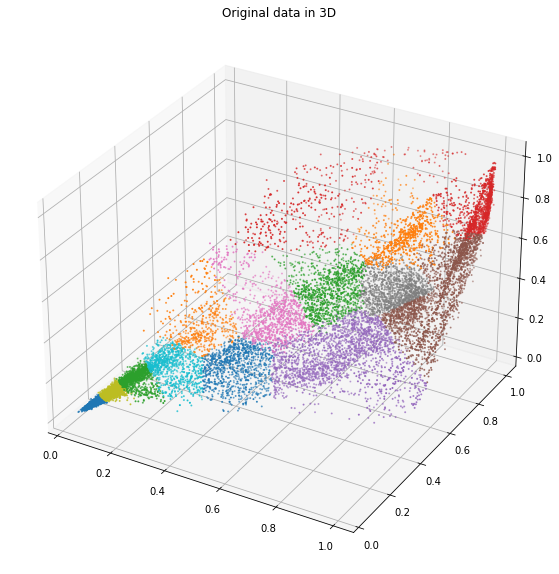

In [25]:
# Creating figure
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection ="3d")

for i in range(K):
    ax.scatter3D(group[i][:, 0], group[i][:, 1], group[i][:, 2], s=1)

plt.title("Original data in 3D")

In [26]:
# 3D->2D
mu, X_norm = feature_normalize(X)

U, S, V = pca(X_norm)

Z = projection(X_norm, U, k=2)

Text(0.5, 1.0, '2D visulization produced using PCA')

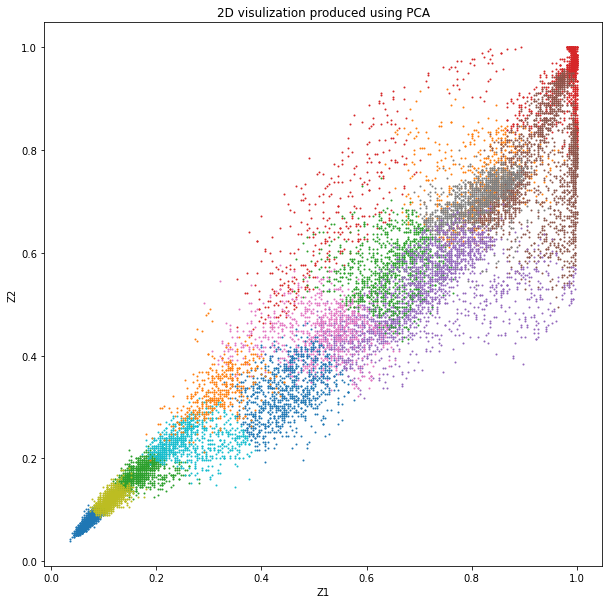

In [27]:
group = []
# 和上面的分组类似，但更加简洁
for i in range(K):
    group.append(np.array([X[j] for j in range(X.shape[0]) if idx[j]==i]))
fig = plt.figure(figsize=(10, 10))

for i in range(len(group)):
    ig = group[i]
    plt.scatter(ig[:, 0], ig[:, 1], s=1)
plt.xlabel('Z1')
plt.ylabel('Z2')
plt.title('2D visulization produced using PCA')